In [1]:

# Task: Solving Blackjack with Q-Learning
# Q-Learning learning adalah salah satu algoritma Reinforcement Learning
# yang berjalan menggunakan sebuah Q-Table, Q-Table adalah kumpulan
# state dari hasil observasi yang dijadikan key dan berisi opsi pilihan terbaik untuk kondisi tersebut
# Proses learning pada Q-Learning pada dasarnya hanya proses untuk membuat Q-Table tersebut.

from __future__ import annotations

# For creating a dictionary with custom default response instead of the default KeyError
from collections import defaultdict

# Plotting a data
import matplotlib.pyplot as plt

# Numpy
import numpy as np

# For Easier good looking data plotting
import seaborn as sns

# For Creating shapes easily, also why is this called Artist?
from matplotlib.patches import Patch

# For creating progress bar
from tqdm import tqdm

import gymnasium as gym
# Creating the blackjack environtment.
env = gym.make('Blackjack-v1', sab=True)

# Reset the environtment to get the first observation
done = False
observation, info = env.reset()
# Observation is a Tuple with 3 values (16, 9, False)
# - The players current Sum
# - Value of the dealers face-up card
# - Boolean whether the player holds a usable ace (An Ace is usable if it counts as 11 without busting)

action = env.action_space.sample()

# execute the action in our environment and receive infos from the environment.
observation, reward, terminated, truncated, info = env.step(action)

class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        intial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a Learning rate and an epsilon.

        Args:
            learning_rate: The Learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-Value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = intial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.

        The functions that actually generate what action to take, at the beginning
        it will always be generating random action because epsilon is 1.0 and 
        this function cannot generate number bigger than 1.0. But then those
        value is used to create a Q-Table with values tuned with each Episode and
        the epsilon gradually decay untill a certain state where the condition
        is not fulfilled and then instead of generating a random action, try
        and see if it has encountered this situation before and choose which action
        has the biggest value. Also called being greedy.
        """
        # With probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""

        future_q_value = (not terminated) * np.max(self.q_values[next_obs])

        temporal_difference = (
            reward + self.discount_factor *
            future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon,
                           self.epsilon - self.epsilon_decay)

# Agent is done time to train
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
# reduce the exploration over time
epsilon_decay = start_epsilon / (n_episodes / 2)
# epsilon_decay = 1e-5
final_epsilon = 0.1
agent = BlackjackAgent(learning_rate=learning_rate,
                       intial_epsilon=start_epsilon,
                       epsilon_decay=epsilon_decay,
                       final_epsilon=final_epsilon)
 
# Training

# Record cumulative rewards and episode lengths
# https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordEpisodeStatistics
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    # obs = (2, 10, False)
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        # 1st iteration: Random sample = 1

        next_obs, reward, terminated, truncated, info = env.step(action)
        

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    # Why is it only updated once the episode is over?
    # Maybe because we want to try a single epsilon for an episode to see how effective that is
    agent.decay_epsilon()

# Todo: Learn how the code actually works (Mostly done)

100%|██████████| 100000/100000 [00:35<00:00, 2818.77it/s]


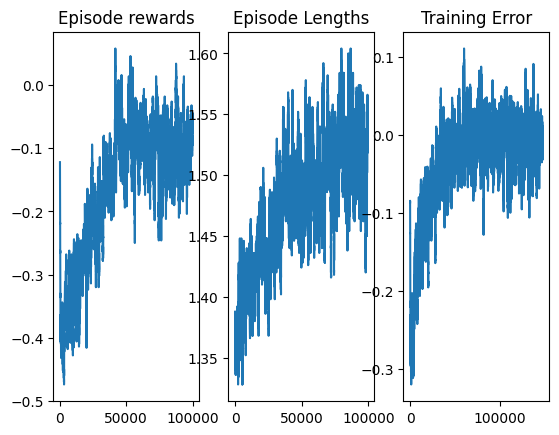

In [51]:
# Todo: Visualize the training

# Window size for the moving average
# Think of it as how many data per iteration should we grab.
window_size = 500 # data per loop


# The cumulative rewards of the last n-many episodes
episode_rewards = np.array(env.return_queue)
# episode_rewards = [[1], [0], [1], [1]]
# flatten(episode_rewards) = [1,0,1,1]

# Plot the Episode Rewards
plt.subplot(131)
plt.title('Episode rewards')

# Perform a moving average (convolution) to smoothen the graph
episode_rewards_moving_average = (
    np.convolve(episode_rewards.flatten(), np.ones(window_size), mode='same') / window_size
)
plt.plot(range(len(episode_rewards_moving_average)), episode_rewards_moving_average)

# The lengths of the last n-many episodes
episode_lengths = np.array(env.length_queue)

# Plot the Episode Lengths
plt.subplot(132)
plt.title('Episode Lengths')
episode_lengths_moving_average = (
    np.convolve(episode_lengths.flatten(), np.ones(window_size), mode='valid') / window_size
)
plt.plot(range(len(episode_lengths_moving_average)), episode_lengths_moving_average)


# Plot The Training error of the last n-many episodes
plt.subplot(133)
plt.title('Training Error')
training_error_moving_average = (
    np.convolve(agent.training_error, np.ones(window_size), mode='same') / window_size
)
plt.plot(range(len(training_error_moving_average)), training_error_moving_average)


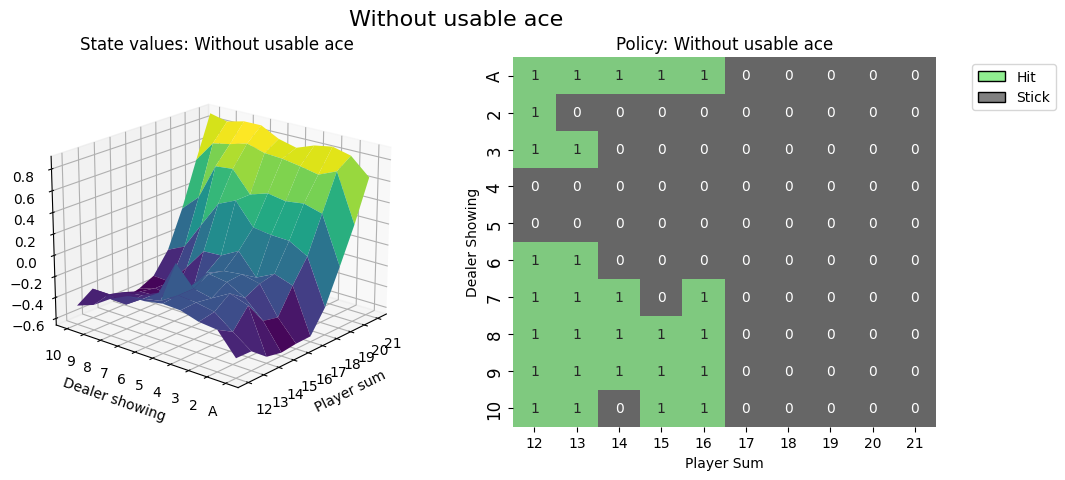

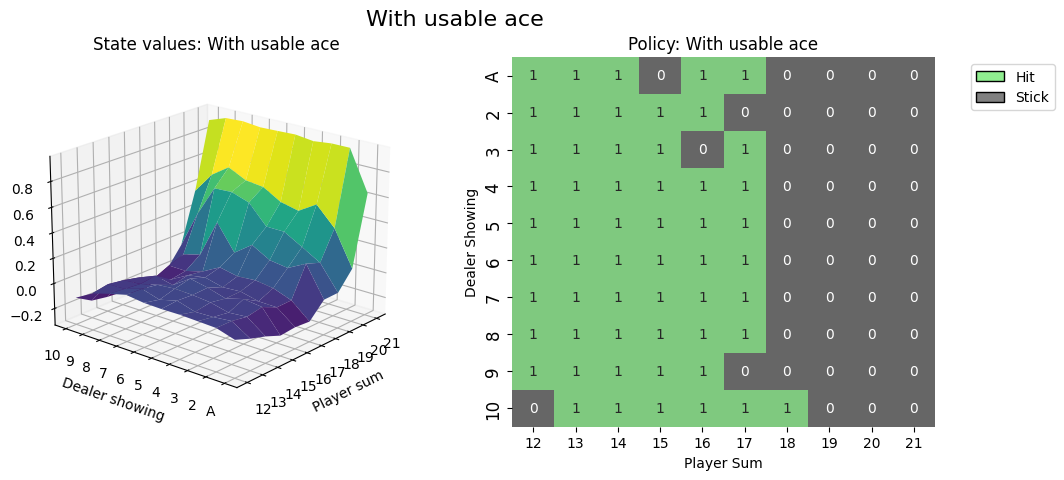

In [95]:
# Todo: Figure out how all this works

# Visualizing the policy

def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        # obs = (10, 1, False) <= Key
        # action_values = [0. 1.02] <= Value
        state_value[obs] = float(np.max(action_values))
        # state_value[(10, 1, False)] = 1.02
        # state_value = {
        #   (10, 1, False): 1.02
        # }
        policy[obs] = int(np.argmax(action_values))
        # policy[(10, 1, False)] = 1
        # policy = {
        #   (10, 1, False): 1
        # }

    player_count, dealer_count = np.meshgrid(
        # Why these two number specifically?
        # Since dealer can only have a number of max 10
        # because only 1faceup card is presented and it cannot
        # go more than 10. See Blackjack card value in google images
        
        # As for the player, why start from 12 while it's possible that player got card that is < 12? 
        # maybe personal choice? We could definitely show the player card from 1 - 21

        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11)
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        # obs[0] = 10
        # obs[1] = 1
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        # This dstack generates a pair of every axis
        # like [0] might be [12,1], then [12,2], [12,3]...n
        # then [1] might be [11, 1], [11, 2] and so on
        # then those value is mappeed to the corresponding observation with the same key
        # which results in every key on the grid having the action value!!!!
        arr=np.dstack([player_count, dealer_count])
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count])
    )
    return value_grid, policy_grid

def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (Left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    #plot the state values
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap='viridis',
        edgecolor='none'
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(122)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player Sum")
    ax2.set_ylabel("Dealer Showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a Legend
    legend_elements = [
        Patch(facecolor='lightgreen', edgecolor='black', label='Hit'),
        Patch(facecolor='grey', edgecolor='black', label='Stick'),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig1 = create_plots(value_grid, policy_grid, "Without usable ace")

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig2 = create_plots(value_grid, policy_grid, "With usable ace")

plt.show()